In [1]:
import cv2
import numpy as np
from cv2 import imread
from scipy import spatial
import scipy
import random
import os
import matplotlib.pyplot as plt

In [2]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them.
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        # print(len(dsc))
        # print(dsc)
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc

In [3]:
class Matcher(object):

    def __init__(self, images_path, pickled_db_path="features.pck"):
        files = [os.path.join(images_path, p)
                 for p in sorted(os.listdir(images_path))]
        result = {}
        for f in files:
            print('Extracting features from image %s' % f)
            name = f.split('/')[-1].lower()
            result[name] = extract_features(f)

        self.data = result
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()



Extracting features from image resources/images/image1.jpg
Extracting features from image resources/images/image10.jpg
Extracting features from image resources/images/image11.jpg
Extracting features from image resources/images/image12.jpg
Extracting features from image resources/images/image13.jpg
Extracting features from image resources/images/image14.jpg
Extracting features from image resources/images/image15.jpg
Extracting features from image resources/images/image16.jpg
Extracting features from image resources/images/image17.jpg
Extracting features from image resources/images/image18.jpg
Extracting features from image resources/images/image19.jpg
Extracting features from image resources/images/image2.jpg
Extracting features from image resources/images/image20.jpg
Extracting features from image resources/images/image21.jpg
Extracting features from image resources/images/image22.jpg
Extracting features from image resources/images/image23.jpg
Extracting features from image resources/i

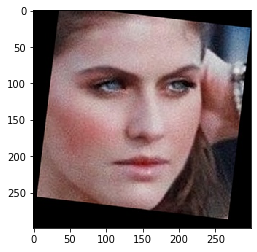

Result images ========================================
Match 0.9999999999999999


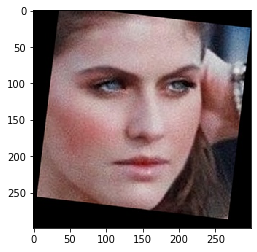

Match 0.6600217508702202


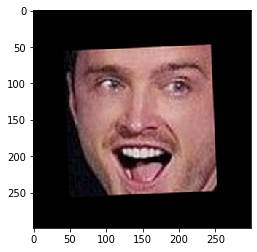

Match 0.6596560786480459


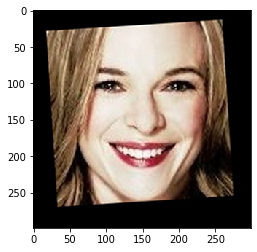

Match 0.6514168839731527


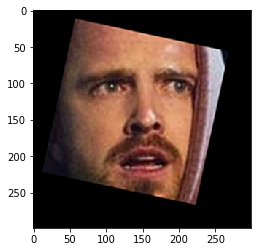

Match 0.6488826913886082


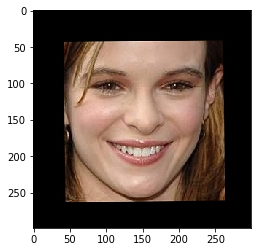

Match 0.6453855752819351


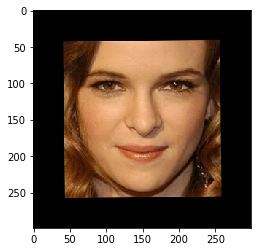

Match 0.6414873086987527


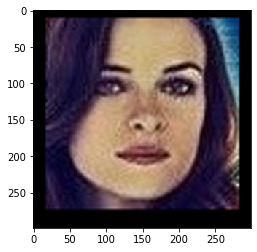

Match 0.6387496310480797


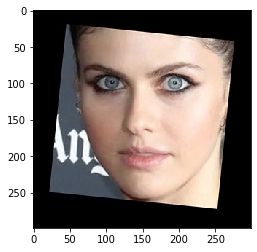

Match 0.6385471823277689


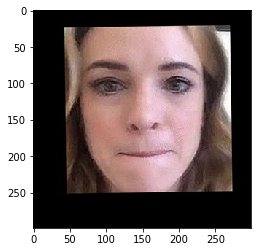

Match 0.6346658291573802


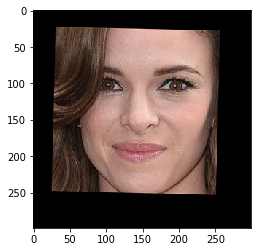

Query image ==========================================


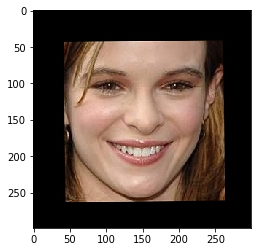

Result images ========================================
Match 1.0


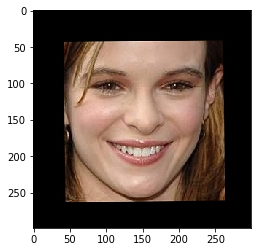

Match 0.6961582034974924


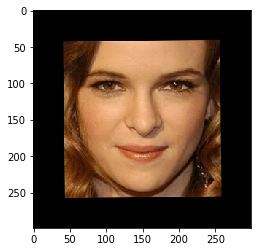

Match 0.6794034951301566


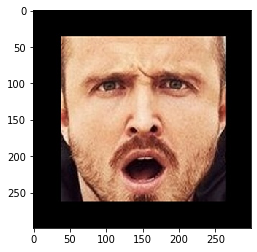

Match 0.6732887070991418


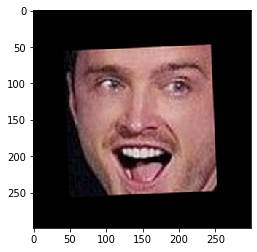

Match 0.6682614266554407


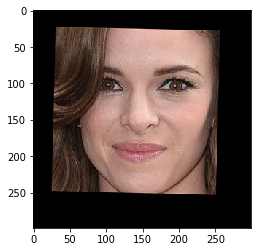

Match 0.6668129503178143


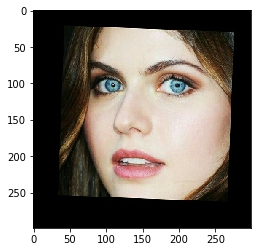

Match 0.6641088069869023


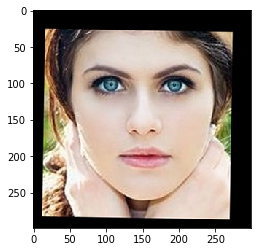

Match 0.6620535194219851


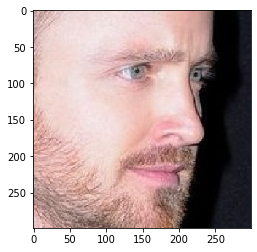

Match 0.6608009840415939


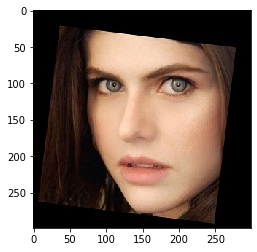

Match 0.6514901260837033


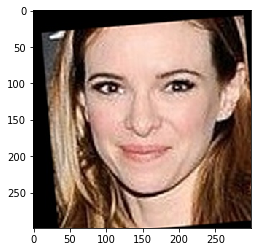

In [7]:
def show_img(path):
    img = imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()


def run():
    images_path = 'resources/images/'
    files = [os.path.join(images_path, p)
             for p in sorted(os.listdir(images_path))]
    # getting 3 random images
    sample = random.sample(files, 2)

    ma = Matcher(images_path)

    for s in sample:
        print('Query image ==========================================')
        show_img(s)
        names, match = ma.match(s, topn=10)
        print('Result images ========================================')
        for i in range(10):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print('Match %s' % (1-match[i]))
            show_img(os.path.join(images_path, names[i]))
            
run()